In [1]:
!pip install tensorflow
!pip install matplotlib


  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached wrapt-1.16.0-cp310-cp310-win_amd64.whl.metadata (6.8 kB)
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     ---------------------------------------- 46.2/46.2 kB 1.2 MB/s eta 0:00:00
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.9 MB ? eta -:--:--
   ---------------------------------------- 0.2/376.9 MB 4.6 MB/s eta 0:01:22
   ---------------------------------------- 0.4/376.9 MB 4.9 MB/s eta 0:01:18
   ---------------------------------------- 1.0/376.9 MB 8.3 MB/s eta 0:00:46
   ---------------------------------------- 2.5/376.9 MB 14.6 MB/s eta 0:00:26
   ---------------------------------------- 4.1/376.9 MB 18.9 MB/s eta 0:00:20
    --------------------------------------

In [13]:
#Imports
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [3]:
# Remove corrupted images
num_skipped = 0
for folder_name in ("organic", "recyclable"):
    folder_path = os.path.join("waste_dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [16]:
image_size = (128, 128)
batch_size = 128

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "waste_dataset",
    validation_split=0.2,
    subset="both",
    seed=1998,
    image_size=image_size,
    batch_size=batch_size,
)

Found 24705 files belonging to 2 classes.
Using 19764 files for training.
Using 4941 files for validation.


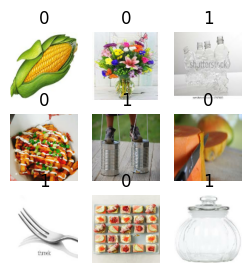

In [17]:
# visualize some images
plt.figure(figsize=(3, 3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [18]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    layers.RandomTranslation(0.1, 0.1),
]


def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

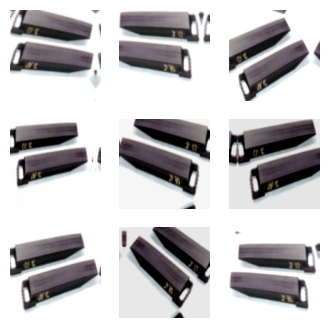

In [19]:
plt.figure(figsize=(4, 4))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [20]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [21]:
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

# Model creation using ResNet50
def make_model(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False  # Freeze the convolutional base

    return model

input_shape = image_size + (3,)
num_classes = 1  # Binary classification

model = make_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

The training did take about 92mins for the base model and x hours for the fine tuning so if you need to rerun that be patient and calculate this times in to your preparations.

In [23]:
epochs = 20
callbacks = [
    keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - acc: 0.8221 - loss: 0.4414 - val_acc: 0.9148 - val_loss: 0.2244
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - acc: 0.9026 - loss: 0.2472 - val_acc: 0.9190 - val_loss: 0.2141
Epoch 3/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - acc: 0.9062 - loss: 0.2361 - val_acc: 0.9223 - val_loss: 0.1995
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - acc: 0.9153 - loss: 0.2145 - val_acc: 0.9221 - val_loss: 0.2048
Epoch 5/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 371s 2s/step - acc: 0.9184 - loss: 0.2090 - val_acc: 0.9334 - val_loss: 0.1786
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step - acc: 0.9188 - loss: 0.2056 - val_acc: 0.9310 - val_loss: 0.1786
Epoch 7/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 353s 2s/step - acc: 0.9194 - loss: 0.2029 - val_acc: 0.9306 - val_loss: 0.1838
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - acc: 0.9260 - loss: 0.1912 - val_acc: 0.9320 - val_loss: 0.1823
Epoch 9/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 375s 2s/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
This image is 49.75% organic and 50.25% recyclable.


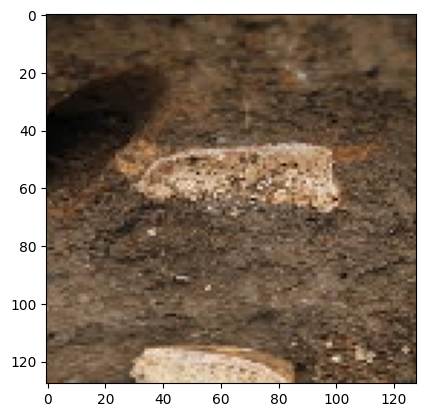

In [29]:
# Evaluate and predict
img = keras.utils.load_img("waste_dataset/organic/organic_000010_photo.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(keras.activations.sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% organic and {100 * score:.2f}% recyclable.")


In [30]:
# Fine-tuning the model
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 15/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 431s 3s/step - accuracy: 0.9325 - loss: 0.1657 - val_accuracy: 0.9320 - val_loss: 0.1776
Epoch 16/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.9366 - loss: 0.1626 - val_accuracy: 0.9356 - val_loss: 0.1726
Epoch 17/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 412s 3s/step - accuracy: 0.9392 - loss: 0.1602 - val_accuracy: 0.9344 - val_loss: 0.1687
Epoch 18/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 408s 3s/step - accuracy: 0.9399 - loss: 0.1545 - val_accuracy: 0.9358 - val_loss: 0.1773
Epoch 19/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9401 - loss: 0.1501 - val_accuracy: 0.9358 - val_loss: 0.1729
Epoch 20/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.9445 - loss: 0.1485 - val_accuracy: 0.9354 - val_loss: 0.1766
Epoch 21/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - accuracy: 0.9478 - loss: 0.1397 - val_accuracy: 0.9389 - val_loss: 0.1657
Epoch 22/30
155/155 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.9450 - loss: 0.1362 - 